## Configure Defaults

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
#! pip install tensorflow==2.4.0
#! pip install tensorflow

Import Dependencies

In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
# Transformer components
from core.transformer import PositionalEmbedding

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

2024-12-04 07:31:03.386184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 07:31:03.401709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 07:31:03.425644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 07:31:03.425666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 07:31:03.440383: I tensorflow/core/platform/cpu_feature_gua

## Dataset

### 1. Generate Data

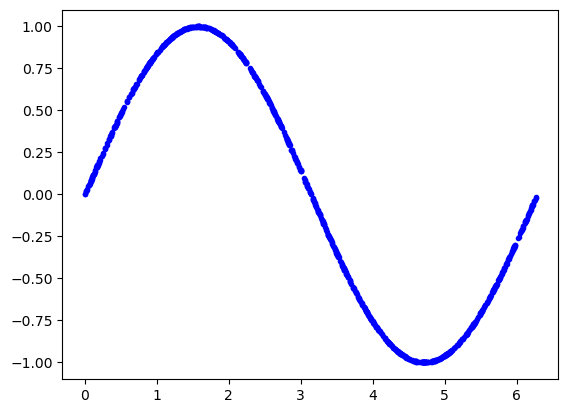

In [4]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise

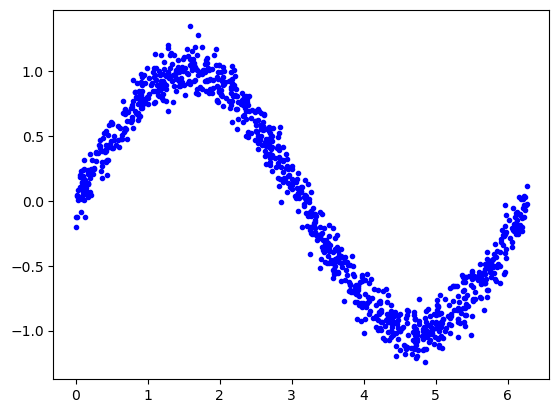

In [5]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data

  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 


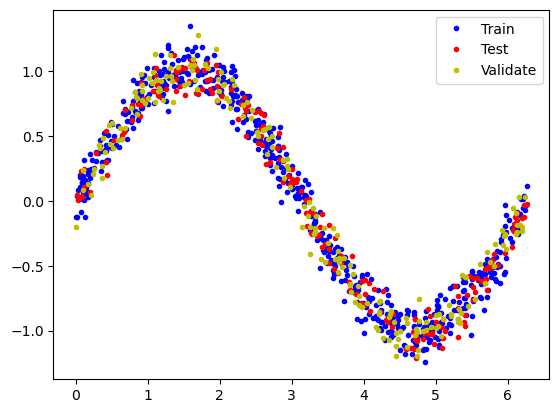

In [6]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Training

### 1. Design the Model

In [7]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

2024-12-04 07:31:05.893952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 07:31:05.942250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 07:31:05.946044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 2. Train the Model

In [8]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=10, batch_size=64,
                        validation_data=(x_validate, y_validate))

Epoch 1/10


I0000 00:00:1733297477.614912   15574 service.cc:145] XLA service 0x7fdd100b8b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733297477.614948   15574 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-04 07:31:17.621326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 07:31:17.640454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1733297477.695572   15574 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 12s 40ms/step - loss: 25.6862 - mae: 4.0945 - val_loss: 24.9186 - val_mae: 4.0378
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 23.4140 - mae: 3.8896 - val_loss: 22.7283 - val_mae: 3.8343
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 21.3540 - mae: 3.6926 - val_loss: 20.6813 - val_mae: 3.6362
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 19.4048 - mae: 3.5029 - val_loss: 18.8029 - val_mae: 3.4481
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 17.6598 - mae: 3.3245 - val_loss: 17.0579 - val_mae: 3.2699
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 15.9876 - mae: 3.1513 - val_loss: 15.4770 - val_mae: 3.1047
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 14.4747 - mae: 2.9911 - val_loss: 14.0299 - val_mae: 2.9500
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 13.1080 - mae

### 3. Plot Metrics

**1. Loss (or Mean Squared Error)**

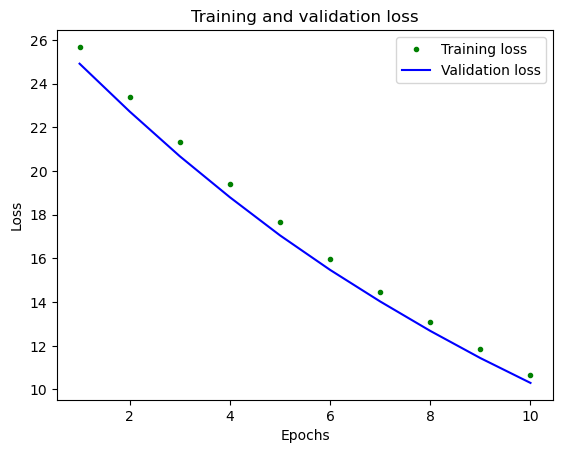

In [9]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

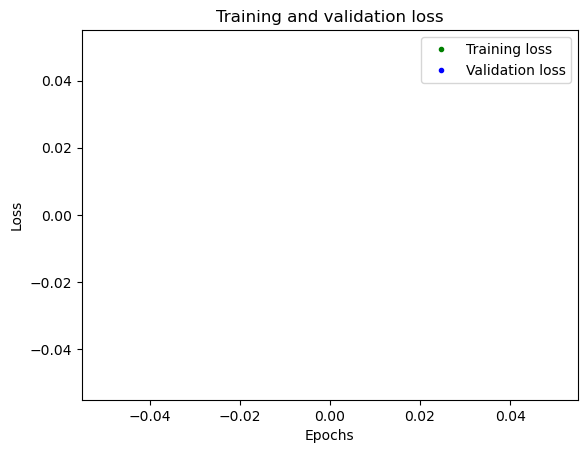

In [10]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**2. Mean Absolute Error**

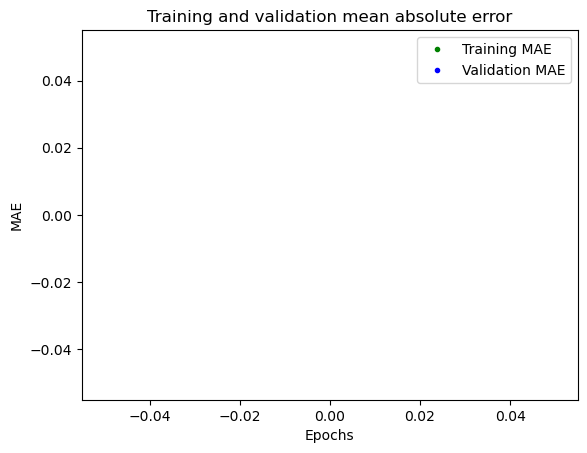

In [11]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**3. Actual vs Predicted Outputs**

7/7 [==============================] - 0s 1ms/step


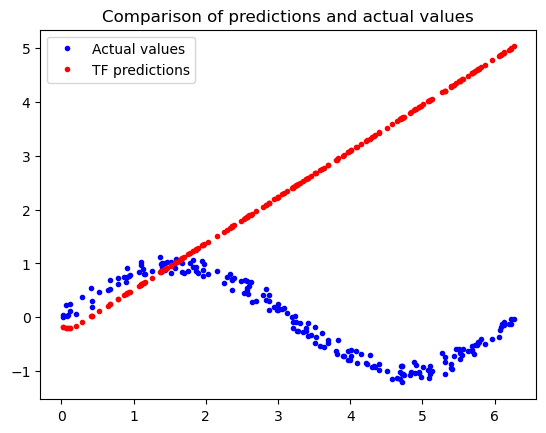

In [12]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

## Training a Larger Model

### 1. Design the Model

### 1.1 Design Prototype

In [13]:
model = tf.keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(keras.layers.Reshape((1, 16)))  # Reshape to (batch_size, steps, input_dim)
model.add(keras.layers.Conv1D(32, 1, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Reshape((1, )))
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

In [14]:
#inputs = keras.Input(shape=(1, 1))
#x = keras.layers.Dense(32, activation="relu")(inputs)
#x = keras.layers.Conv1D(1, 1, strides=1, activation='relu')(x)  #Conv1D layer first
#x = keras.layers.Flatten()(x) #Flatten the output of Conv1D
#x = keras.layers.Dense(64, activation="relu")(x)
#outputs = keras.layers.Dense(1)(x)
#model = keras.Model(inputs=inputs, outputs=outputs, name="seq_model")
#model.compile(optimizer='adam', loss="mse", metrics=["mae"])

In [15]:
print(x_train.shape)
model.summary()

(600,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 reshape (Reshape)           (None, 1, 16)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             544       
                                                                 
 dense_3 (Dense)             (None, 1, 16)             528       
                                                                 
 dense_4 (Dense)             (None, 1, 1)              17        
                                                                 
 reshape_1 (Reshape)         (None, 1)                 0         
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 

### 2. Train the Model ###

In [16]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/10
10/10 [==============================] - 3s 58ms/step - loss: 0.4564 - mae: 0.5574 - val_loss: 0.4371 - val_mae: 0.5778
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.4182 - mae: 0.5670 - val_loss: 0.4098 - val_mae: 0.5573
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3807 - mae: 0.5225 - val_loss: 0.3875 - val_mae: 0.5323
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3635 - mae: 0.5065 - val_loss: 0.3643 - val_mae: 0.5229
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3402 - mae: 0.4976 - val_loss: 0.3453 - val_mae: 0.5107
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3211 - mae: 0.4821 - val_loss: 0.3251 - val_mae: 0.4960
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3020 - mae: 0.4669 - val_loss: 0.3054 - val_mae: 0.4829
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2824 - mae: 0.

INFO:tensorflow:Assets written to: models/model/assets


### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 500/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0882 - val_loss: 0.0115 - val_mae: 0.0865
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

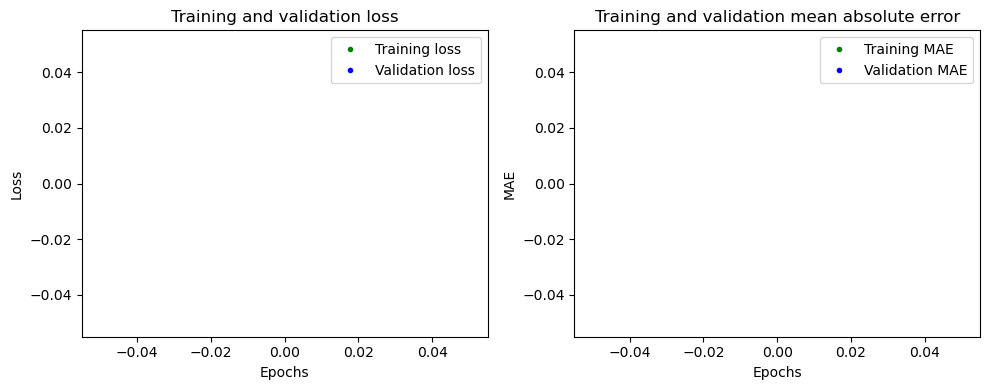

In [17]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 4ms/step


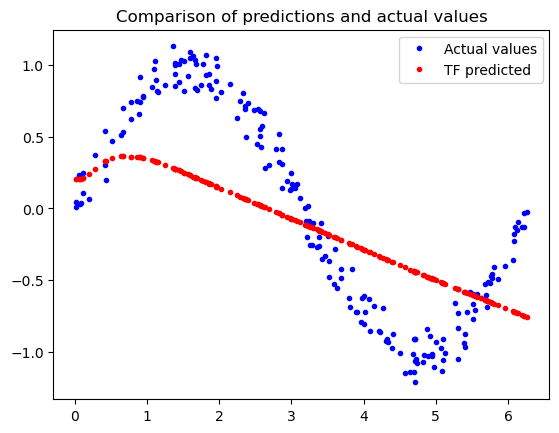

In [18]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

## Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization

In [19]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter._experimental_disable_per_channel_quantization_for_dense_layers = True
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

W0000 00:00:1733297485.174322   15429 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1733297485.174345   15429 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-12-04 07:31:25.174649: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: models/model
2024-12-04 07:31:25.176747: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-12-04 07:31:25.176764: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: models/model
2024-12-04 07:31:25.191440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-12-04 07:31:25.192779: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-12-04 07:31:25.245726: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: models/model
2024-12-04 07:31:25.260362: I tensorflow/cc/saved_model/loader.cc:317] SavedM

10776

### 2. Compare Model Performance

**Helper functions**

In [20]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [21]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

7/7 [==============================] - 0s 4ms/step


INFO: Created TensorFlow Lite XNNPACK delegate for CPU./tmp/ipykernel_15429/3669722529.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = interpreter.get_tensor(output_details["index"])[0]



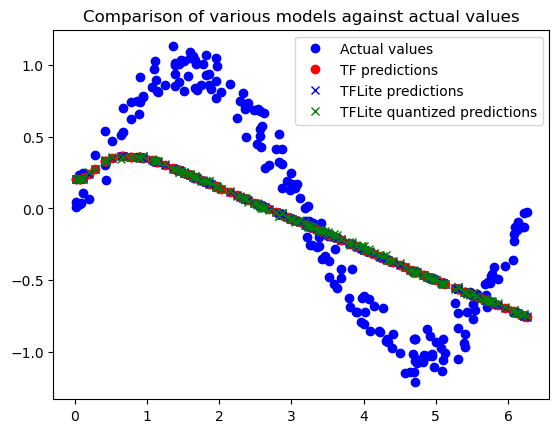

In [22]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

**2. Loss (MSE/Mean Squared Error)**

In [23]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

/tmp/ipykernel_15429/3669722529.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = interpreter.get_tensor(output_details["index"])[0]


In [24]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

,Loss/MSE
Model,
TensorFlow,0.2312
TensorFlow Lite,0.2312
TensorFlow Lite Quantized,0.2313


**3. Size**

In [25]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [26]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,12404 bytes,(reduced by -8308 bytes)
TensorFlow Lite Quantized,10776 bytes,(reduced by 1628 bytes)


## Generate a TensorFlow Lite for Microcontrollers Model

In [27]:
# Install xxd if it is not available
#!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

## Deploy to a Microcontroller

In [28]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0x0c, 0x01, 0x00, 0x00,
  0xf0, 0x08, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x04, 0x29, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xe6, 0xf0, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x68, 0xff, 0xff, 0xff,
  0x33, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00,
  0x72, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x5f, 0x31, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xee, 0xf0, 0xff, 0xff,
  0x04, 0x